In [86]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.ERROR)
import sys

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
0.76470596


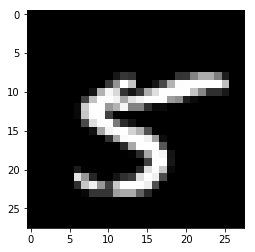

In [97]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [18]:
eval_data = Exposure(eval_data,+60)

In [98]:
train_data_temp = np.copy(train_data)
train_data_temp = SP.Scaling(SP.Rotation(train_data_temp,45),0.4)
train_labels_temp = np.copy(train_labels)

In [99]:
train_data = np.concatenate((train_data,train_data_temp))
train_labels = np.concatenate((train_labels,train_labels_temp))

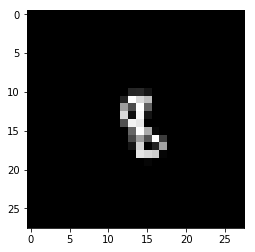

In [100]:
SP.Display(train_data,55000+3441)

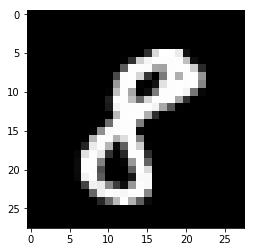

In [101]:
SP.Display(train_data,3441)

In [29]:
eval_data = SP.Rotation(eval_data,30)

In [69]:
eval_data = Translation(eval_data,2)

0.76470596


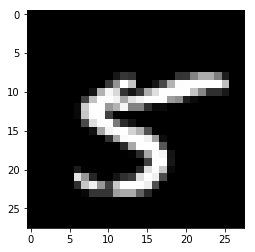

In [102]:
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [103]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=8,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=16,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 16])

    dense = tf.layers.dense(
        inputs=pool2_flat, units=120, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)

        #"classes": temp,
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy":
        tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [118]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_convnet_model_small_scale_0.4")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [119]:
def current_loss(flag):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=mnist_classifier.evaluate(input_fn=train_eval_input_fn)
    if flag:
        print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=mnist_classifier.evaluate(input_fn=eval_input_fn)
    if flag:
        print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()
    return a[1],d[1]

In [121]:
# print("started\n")
# # Train the model
# while 1:
    
# # Train the model
#     print("Training")
#     train_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": train_data},
#       y=train_labels,
#       batch_size=256,
#       num_epochs=None,
#       shuffle=True)

#     mnist_classifier.train(
#       input_fn=train_input_fn,
#       steps=500,
#       hooks=[logging_hook])
#     curr_result = current_loss(0)
#     print(curr_result)
# #     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
# #        break
#     #print(curr_result)
    
# print ("Finished")

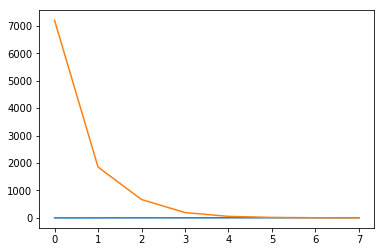

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [124]:
SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9921273, 'loss': 0.023121089, 'global_step': 2502}
######### Test accuracy #############
 {'accuracy': 0.8669, 'loss': 0.4065161, 'global_step': 2502}


In [123]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
eval_data = SP.Scaling(eval_data,0.4)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
